In [6]:
#hide
from fastdot import *
from fastcore.all import *
from dataclasses import dataclass

# fastdot

> A simple wrapper over `pydot` to make it more consistent, unsurprising, and pythonic

Acknowledgement: `fastdot` is heavily influenced by work from [David Page](https://github.com/davidcpage/), who built a system for drawing graphs based on a highly flexible data structure he designed. It may turn out that his library, when complete, will make it even easier to do the things described here (and his data structure also supports a lot more than just drawing)!

## Install

You can install fastdot on your own machines with conda (highly recommended). If you're using Anaconda then run:

```bash
conda install -c fastai -c anaconda fastdot
```
...or if you're using miniconda) then run:
```bash
conda install -c fastai -c fastdot
```

Alternatively, if you want to use pip and you're on a debian based OS you can run:
```bash
sudo apt-get install -y python-pydot python-pydot-ng graphviz
pip install fastdot
```

## Synopsis

Start with some data representing objects and connections between them (e.g. they wouldn't normally be just strings like in this example, but would be neural net layers, or users and products, or car trips, etc):

In [7]:
layers1 = ['conv','conv','lin']
layers2 = ['conv','lin']
block1,block2 = ['block1','block2']
conns = ((block1, block2),
         (block1, layers2[-1]))

Then map them directly to a visual respresentation:

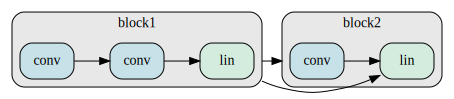

In [8]:
g = graph_items(seq_cluster(layers1, block1),
                seq_cluster(layers2, block2))
g.add_items(*object_connections(conns))
g

See the *symbolic graphs* and *object graphs* sections below for a more complete example.

## fastdot overview

`fastdot` is a thin wrapper over the excellent [pydot](https://github.com/pydot/pydot) program (which is in turn a thin wrapper over the absolutely wonderful [Graphviz software](https://www.graphviz.org/)), designed to make it more consistent, unsurprising, and pythonic. (An example of removing *surprise*: `pydot.Node('node')` gives an obscure compilation exception, since `node` is a keyword in the underlying `graphviz` program, whereas `fastdot.Node('node')` works just fine, due to auto-quoting.) In fact, you never need to provide names in `fastdot`; you can create edges directly between objects.

Here's a quick example of some of the main functionality:

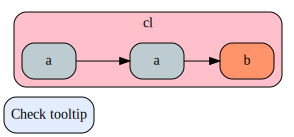

In [9]:
g = Dot()
c = Cluster('cl', fillcolor='pink')
a1,a2,b = c.add_items('a', 'a', 'b')
c.add_items(a1.connect(a2), a2.connect(b))
g.add_item(Node('Check tooltip', tooltip="I have a tooltip!"))
g.add_item(c)
g

As you see, graphs know how to show themselves in Jupyter notebooks directly and can be exported to HTML (it uses SVG behind the scenes). Tooltips appear in both notebooks and exported HTML pages. Nodes with the same label, by default, are set to the same color. Also, as shown above, you can just use `add_item` or `add_items`, regardless of the type of item.

## Symbolic graphs

`fastdot` is particularly designed to make it easier to create graphs symbolically - for instance, for Python dictionaries, PyTorch/TensorFlow models, and so forth. Here's a simple example with some mock neural network layers and sequential models. First, let's define our mock classes:

In [10]:
@dataclass(frozen=True)
class Layer: name:str; n_filters:int=1
class Linear(Layer): pass
class Conv2d(Layer): pass

@dataclass(frozen=True)
class Sequential: layers:list; name:str

Here's our sequential blocks for our "model":

In [11]:
block1 = Sequential([Conv2d('conv', 5), Linear('lin', 3)], 'block1')
block2 = Sequential([Conv2d('conv1', 8), Conv2d('conv2', 2), Linear('lin')], 'block2')

`fastdot` can create all node properties directly from objects; you just have to define functions describing how to map the object's attributes to graph properties. These mappings go in the `node_defaults` and `cluster_defaults` dictionaries (although by default labels are set using `str()`, so we don't need any special cluster defaults in this case):

In [12]:
node_defaults['fillcolor'] = lambda o: 'greenyellow' if isinstance(o,Linear) else 'pink'
cluster_defaults['label'] = node_defaults['label'] = attrgetter('name')
node_defaults['tooltip'] = str

With that in place, we can directly create nodes from our objects, for instance using the convenient `seq_cluster` function:

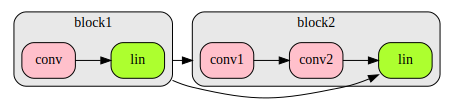

In [13]:
c1 = seq_cluster(block1.layers, block1)
c2 = seq_cluster(block2.layers, block2)
e1,e2 = c1.connect(c2),c1.connect(c2.last())
graph_items(c1,c2,e1,e2)

Note that in this example we didn't even need to create the `Dot` object separately - `graph_items` creates it directly from the graph items provided.

## Using object graphs

In the above example, we defined our edges directly between `fastdot` objects. In practice, however, you'll most likely have your edges defined directly between python objects, for instance like this:

In [14]:
conns = (
    (block1, block2),
    (block1, block2.layers[-1]),
)

In this case, you'll want some way to connect your python objects to the `fastdot` graph items that represent them. A mapping is stored automatically by `fastdot`, and is made available through the `object2graph` function:

In [15]:
g = graph_items(seq_cluster(block1.layers, block1), seq_cluster(block2.layers, block2))
object2graph(block1.layers[-1])

You can use this to graph your connections without needing access to the graph items:

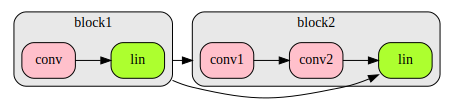

In [16]:
g.add_items(*[object2graph(a).connect(object2graph(b))
              for a,b in conns])
g

There's a helper function, `object_connections`, which creates these connections for you. So the above can be simplified to:

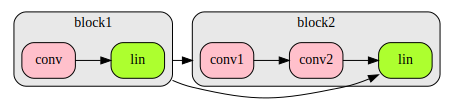

In [17]:
g = graph_items(seq_cluster(block1.layers, block1), seq_cluster(block2.layers, block2))
g.add_items(*object_connections(conns))
g

In [20]:
# hide
# !nbdev_build_docs